# 📊 Comparativa de APIs de Noticias

| API             | Límite Gratuito             | Cobertura                  | Datos Proporcionados                                     | Análisis de Sentimiento | Ordenación Disponible            | Idiomas |
|----------------|----------------------------|----------------------------|----------------------------------------------------------|--------------------------|----------------------------------|---------|
| **GNews.io**   | 100 solicitudes/día, 10 artículos máx. por solicitud | Noticias generales y tecnológicas | Título, URL, fuente, descripción, imagen                 | ❌ No                     | Relevancia, Fecha                | ✅ Sí |
| **TheNewsAPI** | 100 solicitudes/día, 3 artículos máx. por solicitud  | Noticias generales            | Título, URL, fuente, resumen                             | ❌ No                     | Relevancia, Fecha                | ✅ Sí |

In [1]:
from bs4 import BeautifulSoup
import os

In [2]:
# API Keys
GNEWS_API_KEY = "087e2241d8a55daf522083c0ddab7547"
THENEWS_API_KEY = "PBqwcAoCbsLtDB2FF8NQNxpjOEeGQSkzu4tGB79E"

In [3]:
# Utility functions
def format_duration(td):
    total_seconds = int(td.total_seconds())
    hours = total_seconds // 3600
    minutes = (total_seconds % 3600) // 60
    seconds = total_seconds % 60
    return f"{hours:02}:{minutes:02}:{seconds:02}"

def get_clean_article_content(url):
    """Devuelve el texto del artículo o None si hubo cualquier error."""
    try:
        headers = {"User-Agent": "Mozilla/5.0"}
        resp = requests.get(url, headers=headers, timeout=10)
        if resp.status_code != 200:
            return None
        soup = BeautifulSoup(resp.text, 'html.parser')
        for tag in ["script", "style", "aside", "nav", "footer", "header", "form", "button"]:
            for el in soup.find_all(tag):
                el.decompose()
        paragraphs = [p.get_text().strip() for p in soup.find_all("p")]
        article = "\n".join([t for t in paragraphs if t])
        # descartamos artículos demasiado cortos
        if len(article) < 100:
            return None
        return article
    except Exception:
        return None

def scrape_article_contents(df, url_column="urls", content_column="article_contents", delay=2):
    print(f"🔎 Starting article scraping for {len(df)} days...")
    start_time = datetime.now()

    for index, row in df.iterrows():
        date_info = row.get("date", f"index {index}")
        print(f"\n📆 Scraping articles for {date_info}...")

        article_texts = []
        urls = row.get(url_column, [])

        if not isinstance(urls, list) or not urls:
            print(f"⚠️ No valid URLs to scrape for {date_info}. Skipping.")
            df.at[index, content_column] = []
            continue

        total_urls = len(urls)
        for i, url in enumerate(urls, 1):
            print(f"🔍 Scraping URL {i}/{total_urls} for {date_info}")
            try:
                content = get_clean_article_content(url)
                article_texts.append(content)
            except Exception as e:
                article_texts.append(f"❌ Error scraping {url}: {str(e)}")
            time.sleep(delay)

        df.at[index, content_column] = article_texts

    end_time = datetime.now()
    duration = end_time - start_time
    print(f"\n✅ Finished scraping. Duration: {format_duration(duration)}")
    return df

from datetime import datetime, timedelta
import time
import requests
import pandas as pd

def fetch_gnews_articles(
    start_date, end_date, query,
    language="en", max_articles=10,
    sort_by="publishedAt", delay=2
):
    print("🚀 Starting GNews article collection...")
    news_data = []
    start_time = datetime.now()
    current_date = start_date

    while current_date <= end_date:
        # Skip weekends (5 = Saturday, 6 = Sunday)
        if current_date.weekday() >= 5:
            current_date += timedelta(days=1)
            continue

        formatted_date = current_date.strftime("%Y-%m-%d")
        from_date     = current_date.strftime("%Y-%m-%dT00:00:00Z")
        to_date       = current_date.strftime("%Y-%m-%dT23:59:59Z")

        print(f"📅 Fetching articles for {formatted_date}...")

        url = (
            f"https://gnews.io/api/v4/search?"
            f"q={query}&lang={language}&max={max_articles}"
            f"&sortby={sort_by}&from={from_date}&to={to_date}"
            f"&category=business,technology&apikey={GNEWS_API_KEY}"
        )
        try:
            response = requests.get(url, timeout=10)
            titles, urls, sources, descriptions = [], [], [], []

            if response.status_code == 200:
                data = response.json()
                articles = data.get("articles", [])
                if articles:
                    print(f"✅ {len(articles)} articles found for {formatted_date}")
                    for article in articles:
                        titles.append(article.get("title", ""))
                        urls.append(article.get("url", ""))
                        sources.append(article.get("source", {}).get("name", ""))
                        descriptions.append(article.get("description", ""))
                else:
                    print(f"⚠️ No articles found for {formatted_date}")
            else:
                print(f"❌ Error {response.status_code} on {formatted_date}: {response.text}")

            news_data.append({
                "date": formatted_date,
                "titles": titles,
                "urls": urls,
                "sources": sources,
                "descriptions": descriptions
            })

        except Exception as e:
            print(f"❌ Exception while fetching {formatted_date}: {e}")

        # Advance to next day
        current_date += timedelta(days=1)
        time.sleep(delay)

    end_time = datetime.now()
    print("✅ Finished article collection from GNews.")
    print(f"⏱️ Time taken: {format_duration(end_time - start_time)}")

    df = pd.DataFrame(news_data)
    df["article_contents"] = None
    return df

def fetch_thenewsapi_articles(
    start_date, end_date, query,
    language="en", max_articles=3,
    sort_by="relevance_score,published_at", delay=2
):
    print("🚀 Starting TheNewsAPI article collection...")
    news_data = []
    start_time = datetime.now()
    current_date = start_date

    while current_date <= end_date:
        # Skip weekends (5 = Saturday, 6 = Sunday)
        if current_date.weekday() >= 5:
            current_date += timedelta(days=1)
            continue

        formatted_date = current_date.strftime("%Y-%m-%d")
        print(f"📅 Fetching articles for {formatted_date}...")

        url = (
            f"https://api.thenewsapi.com/v1/news/all?"
            f"search={query}&language={language}&limit={max_articles}"
            f"&sort={sort_by}&published_on={formatted_date}"
            f"&api_token={THENEWS_API_KEY}"
        )

        titles, urls, sources, descriptions = [], [], [], []
        try:
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                data = response.json().get("data", [])
                if data:
                    print(f"✅ {len(data)} articles found for {formatted_date}")
                    for article in data:
                        titles.append(article.get("title", ""))
                        urls.append(article.get("url", ""))
                        sources.append(article.get("source", ""))
                        descriptions.append(article.get("description", ""))
                else:
                    print(f"⚠️ No articles found for {formatted_date}")
            else:
                print(f"❌ Error {response.status_code} on {formatted_date}: {response.text}")
        except Exception as e:
            print(f"❌ Exception while fetching {formatted_date}: {e}")

        news_data.append({
            "date": formatted_date,
            "titles": titles,
            "urls": urls,
            "sources": sources,
            "descriptions": descriptions
        })

        # Advance to next day
        current_date += timedelta(days=1)
        time.sleep(delay)

    end_time = datetime.now()
    print("✅ Finished article collection from TheNewsAPI.")
    print(f"⏱️ Time taken: {format_duration(end_time - start_time)}")

    df = pd.DataFrame(news_data)
    df["article_contents"] = None
    return df

def save_monthly_news(df, source_name, start_date, out_dir):
    """
    Guarda df en formato JSON-lines con nombre:
      df-{source_name}-{YYYY}_{MM}.jsonl

    Parámetros:
    - df: DataFrame con columna 'date' + listas (titles, urls, etc.)
    - source_name: p.ej. 'gnews' o 'thenewsapi'
    - start_date: datetime del primer día del mes
    - out_dir: carpeta donde guardar (se crea si no existe)
    """
    # 1) Aseguramos que el directorio existe
    os.makedirs(out_dir, exist_ok=True)

    # 2) Extraemos año/mes
    year  = start_date.year
    month = start_date.month

    # 3) Construimos nombre de fichero con source_name, no con df
    fname = f"df-{source_name}-{year}_{month:02d}.jsonl"
    path  = os.path.join(out_dir, fname)

    # 4) Guardamos
    df.to_json(
        path,
        orient="records",
        date_format="iso",
        lines=True,
        force_ascii=False
    )
    print(f"✅ Saved {len(df)} records to {path}")

In [4]:
# Shared config
start_date = datetime(2024, 12, 1)
end_date = datetime(2024, 12, 31)
delay_seconds = 2

# GNews - gnews.io

In [5]:
# GNews execution
query_gnews = '(Bitcoin OR BTC OR crypto OR cryptocurrency) AND (price OR market OR trading OR volatility)'
df_gnews = fetch_gnews_articles(start_date, end_date, query_gnews, delay=delay_seconds)
df_gnews = scrape_article_contents(df_gnews, delay=delay_seconds)
save_monthly_news(
    df_gnews,
    source_name="gnews",
    start_date=start_date,
    out_dir="gnews_data"
)

🚀 Starting GNews article collection...
📅 Fetching articles for 2024-12-02...
✅ 10 articles found for 2024-12-02
📅 Fetching articles for 2024-12-03...
✅ 6 articles found for 2024-12-03
📅 Fetching articles for 2024-12-04...
✅ 10 articles found for 2024-12-04
📅 Fetching articles for 2024-12-05...
✅ 10 articles found for 2024-12-05
📅 Fetching articles for 2024-12-06...
✅ 10 articles found for 2024-12-06
📅 Fetching articles for 2024-12-09...
✅ 5 articles found for 2024-12-09
📅 Fetching articles for 2024-12-10...
✅ 9 articles found for 2024-12-10
📅 Fetching articles for 2024-12-11...
✅ 8 articles found for 2024-12-11
📅 Fetching articles for 2024-12-12...
✅ 4 articles found for 2024-12-12
📅 Fetching articles for 2024-12-13...
✅ 6 articles found for 2024-12-13
📅 Fetching articles for 2024-12-16...
✅ 10 articles found for 2024-12-16
📅 Fetching articles for 2024-12-17...
✅ 3 articles found for 2024-12-17
📅 Fetching articles for 2024-12-18...
✅ 7 articles found for 2024-12-18
📅 Fetching articles 

# TheNewsAPI - thenewsapi.com

In [6]:
# TheNewsAPI execution
query_thenews = '(Bitcoin OR BTC OR crypto OR cryptocurrency) AND (price OR market OR trading OR volatility)'
df_thenews = fetch_thenewsapi_articles(start_date, end_date, query_thenews, delay=delay_seconds)
df_thenews = scrape_article_contents(df_thenews, delay=delay_seconds)
save_monthly_news(
    df_thenews,
    source_name="thenews",
    start_date=start_date,
    out_dir="thenewsapi_data"
)

🚀 Starting TheNewsAPI article collection...
📅 Fetching articles for 2024-12-02...
✅ 1 articles found for 2024-12-02
📅 Fetching articles for 2024-12-03...
✅ 3 articles found for 2024-12-03
📅 Fetching articles for 2024-12-04...
✅ 1 articles found for 2024-12-04
📅 Fetching articles for 2024-12-05...
✅ 3 articles found for 2024-12-05
📅 Fetching articles for 2024-12-06...
✅ 1 articles found for 2024-12-06
📅 Fetching articles for 2024-12-09...
✅ 3 articles found for 2024-12-09
📅 Fetching articles for 2024-12-10...
✅ 1 articles found for 2024-12-10
📅 Fetching articles for 2024-12-11...
✅ 2 articles found for 2024-12-11
📅 Fetching articles for 2024-12-12...
✅ 2 articles found for 2024-12-12
📅 Fetching articles for 2024-12-13...
✅ 3 articles found for 2024-12-13
📅 Fetching articles for 2024-12-16...
✅ 3 articles found for 2024-12-16
📅 Fetching articles for 2024-12-17...
✅ 3 articles found for 2024-12-17
📅 Fetching articles for 2024-12-18...
✅ 3 articles found for 2024-12-18
📅 Fetching articles 

### join

In [24]:
import glob
import pandas as pd
from transformers import pipeline

In [25]:
def load_api_news(pattern):
    files = sorted(glob.glob(pattern))
    dfs = [pd.read_json(f, orient="records", lines=True) for f in files]
    df = pd.concat(dfs, ignore_index=True)
    df["date"] = pd.to_datetime(df["date"])
    return df.set_index("date")

In [26]:
df_gnews = load_api_news("gnews_data/*.jsonl")
df_thenews = load_api_news("thenewsapi_data/*.jsonl")

In [27]:
df_news = df_gnews.join(
    df_thenews,
    how="outer",
    lsuffix="_gnews",
    rsuffix="_thenews"
)

In [28]:
cols = ["titles","urls","sources","descriptions","article_contents"]
for col in cols:
    gcol = f"{col}_gnews"
    tcol = f"{col}_thenews"
    df_news[col] = (
        df_news[gcol].apply(lambda x: x or []) +
        df_news[tcol].apply(lambda x: x or [])
    )

In [29]:
df_news = df_news.drop(columns=[f"{c}_gnews" for c in cols] + [f"{c}_thenews" for c in cols])

In [30]:
df_news

,titles,urls,sources,descriptions,article_contents
date,,,,,
2024-01-01,"[Bitcoin price surges above $45,000 for first ...",[https://www.livemint.com/market/cryptocurrenc...,"[Livemint, CNBC]",[Bitcoin price surged on expectation that the ...,[Bitcoin price surged over 6% to break above $...
2024-01-02,[The hullabaloo over crypto has quietened desp...,[https://www.livemint.com/opinion/online-views...,"[Livemint, Hot Hardware, CNBC, Business Inside...",[Bitcoin’s price shot up in 2023 but few seeme...,[This is a Mint Premium article gifted to you....
2024-01-03,"[Biggest stock movers today: Crypto stocks, So...",[https://seekingalpha.com/news/4051785-biggest...,"[Seeking Alpha, investing.com, investing.com]",[Stock futures inched lower in the early tradi...,"[None, None, None]"
2024-01-04,"[Bitcoin price in Saudi Arabia on January 4, 2...",[https://www.bolnews.com/business/2024/01/btc-...,"[BOL News, Yahoo Finance, Motley Fool Australi...","[As of January 04, 2024, the Bitcoin market in...","[04th Jan, 2024. 07:22 pm\nShare\nListen\nFont..."
2024-01-05,[Elon Musk drops price of X gold checks amid r...,[https://arstechnica.com/tech-policy/2024/01/c...,"[Ars Technica, Investing.com, Investing.com, i...",[Reports come the same week X reduced the cost...,[There's currently a surge in cryptocurrency a...
...,...,...,...,...,...
2024-12-25,[AMBCrypto Report: December 2024 Crypto Roundu...,[https://ambcrypto.com/ambcrypto-report-decemb...,"[ambcrypto.com, medium.com, medium.com]",[Explore December's crypto highlights: Bitcoin...,[Listed below are the key takeaways for the mo...
2024-12-26,"[Dow ekes out gains, bitcoin slumps as 'Santa ...",[https://finance.yahoo.com/news/live/stock-mar...,"[Yahoo Finance, Yahoo Canada Finance, Yahoo Fi...",[US stocks were set to open post-Christmas tra...,"[Oops, something went wrong\nUS stocks struggl..."
2024-12-27,[Crypto's tailwinds in 2025 could push bitcoin...,[https://www.cnbc.com/2024/12/27/cryptos-tailw...,"[CNBC, Yahoo Finance, BOL News, BOL News, yaho...",[Investors in cryptocurrencies are eager for t...,"[None, Oops, something went wrong\nBitcoin too..."


In [31]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
from scipy.special import softmax
import torch
import pandas as pd

MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForS

In [32]:
def get_sentiment_score(text):
    if not isinstance(text, str) or not text.strip():
        return None  # o 0, según tu preferencia
    encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    sentiment = (-1 * scores[0]) + (0 * scores[1]) + (1 * scores[2])
    return sentiment

In [33]:
def mean_sentiment(article_list):
    if not isinstance(article_list, list) or not article_list:
        return None  # o 0, según tu preferencia
    scores = [get_sentiment_score(article) for article in article_list if isinstance(article, str) and article.strip()]
    if not scores:
        return None  # o 0, según tu preferencia
    return sum(scores) / len(scores)

In [34]:
df_news["mean_sentiment"] = df_news["article_contents"].apply(mean_sentiment)

In [35]:
df_news.head()

,titles,urls,sources,descriptions,article_contents,mean_sentiment
date,,,,,,
2024-01-01,"[Bitcoin price surges above $45,000 for first ...",[https://www.livemint.com/market/cryptocurrenc...,"[Livemint, CNBC]",[Bitcoin price surged on expectation that the ...,[Bitcoin price surged over 6% to break above $...,0.599507
2024-01-02,[The hullabaloo over crypto has quietened desp...,[https://www.livemint.com/opinion/online-views...,"[Livemint, Hot Hardware, CNBC, Business Inside...",[Bitcoin’s price shot up in 2023 but few seeme...,[This is a Mint Premium article gifted to you....,0.302295
2024-01-03,"[Biggest stock movers today: Crypto stocks, So...",[https://seekingalpha.com/news/4051785-biggest...,"[Seeking Alpha, investing.com, investing.com]",[Stock futures inched lower in the early tradi...,"[None, None, None]",NaN
2024-01-04,"[Bitcoin price in Saudi Arabia on January 4, 2...",[https://www.bolnews.com/business/2024/01/btc-...,"[BOL News, Yahoo Finance, Motley Fool Australi...","[As of January 04, 2024, the Bitcoin market in...","[04th Jan, 2024. 07:22 pm\nShare\nListen\nFont...",0.165357
2024-01-05,[Elon Musk drops price of X gold checks amid r...,[https://arstechnica.com/tech-policy/2024/01/c...,"[Ars Technica, Investing.com, Investing.com, i...",[Reports come the same week X reduced the cost...,[There's currently a surge in cryptocurrency a...,-0.506613


In [36]:
df_news.to_parquet('df_news_sentiment.parquet')

In [37]:
print(df_news['mean_sentiment'].describe())

count    250.000000
mean       0.119706
std        0.241144
min       -0.544396
25%       -0.010731
50%        0.098317
75%        0.284741
max        0.918095
Name: mean_sentiment, dtype: float64


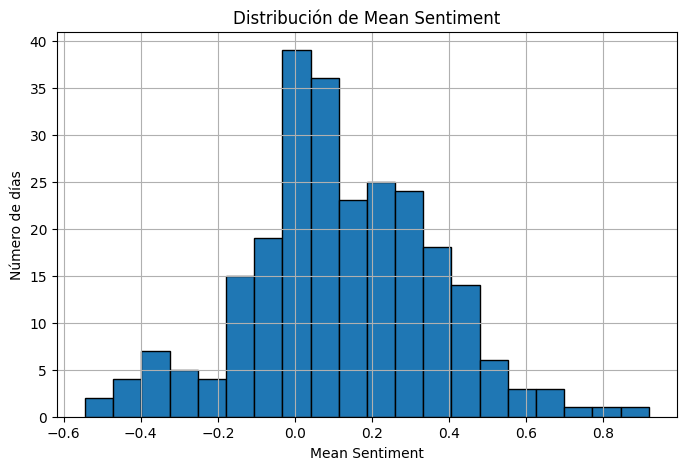

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
df_news['mean_sentiment'].hist(bins=20, edgecolor='black')
plt.title('Distribución de Mean Sentiment')
plt.xlabel('Mean Sentiment')
plt.ylabel('Número de días')
plt.show()


gráfico de barras a lo largo del tiempo!!!!! añadir